In [75]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def read_prices(filename):
    """
    Read prices from a file.
    The file should contain one price per line.
    """
    with open(filename, 'r') as f:
        prices = [float(line.strip()) for line in f]
    return np.array(prices)

In [76]:



def analyse_time_series(series, ts=None, non_negative=False, aut_corr_lags=np.arange(1, 20), windows=None):
    if ts is None:
        ts = np.arange(len(series))
    if windows is None:
        windows = [len(series)//10, len(series)//25]

        

In [77]:
def analyse_time_series(series, ts=None, non_negative=False, aut_corr_lags=np.arange(1, 20), windows=None):
    """
    Generate detailed plots for time series analysis.
    
    Parameters:
    -----------
    series : array-like
        The time series data to analyze
    ts : array-like, optional
        Time points corresponding to the series. If None, uses sequential indices.
    non_negative : bool, default=False
        If True, calculates log returns instead of differences for non-negative data
    aut_corr_lags : array-like, default=np.arange(1, 20)
        Lags to use for autocorrelation analysis
    windows : list, optional
        Window sizes for rolling statistics. If None, uses [len(series)//10, len(series)//25]
    
    Returns:
    --------
    figs : list
        List of matplotlib figure objects
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from statsmodels.tsa.seasonal import seasonal_decompose
    from scipy import signal
    from scipy.fft import fft, fftfreq
    
    if ts is None:
        ts = np.arange(len(series))
    if windows is None:
        windows = [len(series)//10, len(series)//25]
    
    # Convert to pandas Series for easier manipulation
    series_pd = pd.Series(series, index=ts)
    
    # Calculate differences or log returns
    if non_negative:
        # Calculate log returns for non-negative data
        transformed = np.log(series_pd / series_pd.shift(1)).dropna()
        transform_label = 'Log Returns'
    else:
        # Calculate differences
        transformed = series_pd.diff().dropna()
        transform_label = 'First Differences'
    
    figs = []  # List to store all figures
    
    # Helper function for autocorrelation with custom plotting
    def plot_autocorrelation(x, lags, ax, title):
        # Calculate autocorrelation
        acf = np.array([1] + [np.corrcoef(x[:-i], x[i:])[0, 1] for i in range(1, lags+1)])
        lags_array = np.arange(lags+1)
        
        # Plot as line with circles
        ax.plot(lags_array, acf, 'o-', markersize=5)
        ax.axhline(y=0, linestyle='--', color='gray', alpha=0.7)
        
        # Add confidence intervals (95%)
        conf_level = 1.96 / np.sqrt(len(x))
        ax.fill_between(lags_array, -conf_level, conf_level, alpha=0.2, color='blue')
        
        ax.set_title(title)
        ax.set_xlabel('Lag')
        ax.set_ylabel('Autocorrelation')
        ax.grid(True, alpha=0.3)
        return acf
    
    # Figure 1: Original Series, Transformation, and Distributions
    fig1 = plt.figure(figsize=(15, 10))
    gs = fig1.add_gridspec(2, 3)
    
    # Original time series
    ax1 = fig1.add_subplot(gs[0, :2])
    ax1.plot(ts, series, linewidth=1.5)
    ax1.set_title('Original Time Series')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    
    # Histogram of original series
    ax2 = fig1.add_subplot(gs[0, 2])
    series_pd.hist(bins=30, density=True, alpha=0.6, ax=ax2)
    series_pd.plot.kde(ax=ax2, color='red', linewidth=2)
    ax2.set_title('Distribution of Original Series')
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Density')
    ax2.grid(True, alpha=0.3)
    
    # Transformed series
    ax3 = fig1.add_subplot(gs[1, :2])
    ax3.plot(transformed.index, transformed.values, linewidth=1.5, color='green')
    ax3.set_title(f'{transform_label}')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    
    # Histogram of transformed series
    ax4 = fig1.add_subplot(gs[1, 2])
    transformed.hist(bins=30, density=True, alpha=0.6, ax=ax4)
    transformed.plot.kde(ax=ax4, color='red', linewidth=2)
    ax4.set_title(f'Distribution of {transform_label}')
    ax4.set_xlabel('Value')
    ax4.set_ylabel('Density')
    ax4.grid(True, alpha=0.3)
    
    fig1.tight_layout()
    figs.append(fig1)
    
    # Figure 2: Autocorrelation Analysis
    fig2 = plt.figure(figsize=(15, 10))
    gs = fig2.add_gridspec(2, 2)
    
    # ACF of original series
    ax1 = fig2.add_subplot(gs[0, 0])
    plot_autocorrelation(series_pd.values, max(aut_corr_lags), ax1, 'Autocorrelation of Original Series')
    
    # ACF of transformed series
    ax2 = fig2.add_subplot(gs[0, 1])
    plot_autocorrelation(transformed.values, max(aut_corr_lags), ax2, f'Autocorrelation of {transform_label}')
    
    # Lag plot of original series
    ax3 = fig2.add_subplot(gs[1, 0])
    pd.plotting.lag_plot(series_pd, lag=1, ax=ax3)
    ax3.set_title('Lag 1 Plot of Original Series')
    ax3.grid(True, alpha=0.3)
    
    # Lag plot of transformed series
    ax4 = fig2.add_subplot(gs[1, 1])
    pd.plotting.lag_plot(transformed, lag=1, ax=ax4)
    ax4.set_title(f'Lag 1 Plot of {transform_label}')
    ax4.grid(True, alpha=0.3)
    
    fig2.tight_layout()
    figs.append(fig2)
    
    # Figure 3: Fourier Analysis
    fig3 = plt.figure(figsize=(15, 10))
    gs = fig3.add_gridspec(2, 2)
    
    # FFT of original series
    ax1 = fig3.add_subplot(gs[0, :])
    # Compute FFT
    series_fft = fft(series_pd.values)
    n = len(series_pd.values)
    freq = fftfreq(n, d=(ts[1]-ts[0]) if len(ts) > 1 else 1)
    
    # Plot only the positive frequencies (up to Nyquist frequency)
    positive_freq_idx = np.arange(1, n // 2)
    ax1.plot(freq[positive_freq_idx], 2.0/n * np.abs(series_fft[positive_freq_idx]), '-o', markersize=3)
    ax1.set_title('Fourier Transform of Original Series')
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # Log scale for better visualization
    ax1.set_yscale('log')
    
    # FFT of transformed series
    ax2 = fig3.add_subplot(gs[1, :])
    # Compute FFT
    if len(transformed) > 1:  # Ensure we have enough data points
        trans_fft = fft(transformed.values)
        n_trans = len(transformed.values)
        freq_trans = fftfreq(n_trans, d=(transformed.index[1]-transformed.index[0]) if len(transformed.index) > 1 else 1)
        
        # Plot only the positive frequencies
        positive_freq_idx_trans = np.arange(1, n_trans // 2)
        ax2.plot(freq_trans[positive_freq_idx_trans], 
                 2.0/n_trans * np.abs(trans_fft[positive_freq_idx_trans]), 
                 '-o', markersize=3, color='green')
        ax2.set_title(f'Fourier Transform of {transform_label}')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Amplitude')
        ax2.grid(True, alpha=0.3)
        
        # Log scale for better visualization
        ax2.set_yscale('log')
    
    fig3.tight_layout()
    figs.append(fig3)
    
    # Figure 4: Rolling Statistics and Decomposition
    fig4 = plt.figure(figsize=(15, 12))
    
    # Determine grid layout based on whether we'll include decomposition
    include_decomp = len(series) >= 2 * max(windows)
    if include_decomp:
        gs = fig4.add_gridspec(3, 2)
    else:
        gs = fig4.add_gridspec(2, 2)
    
    # Rolling mean for different windows
    ax1 = fig4.add_subplot(gs[0, 0])
    ax1.plot(ts, series, label='Original', alpha=0.5)
    for window in windows:
        rolling_mean = series_pd.rolling(window=window).mean()
        ax1.plot(rolling_mean.index, rolling_mean.values, 
                 label=f'Window={window}', linewidth=2)
    ax1.set_title('Rolling Mean')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rolling standard deviation for different windows
    ax2 = fig4.add_subplot(gs[0, 1])
    for window in windows:
        rolling_std = series_pd.rolling(window=window).std()
        ax2.plot(rolling_std.index, rolling_std.values, 
                 label=f'Window={window}', linewidth=2)
    ax2.set_title('Rolling Standard Deviation')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Rolling autocorrelation (lag 1) for different windows
    ax3 = fig4.add_subplot(gs[1, 0])
    for window in windows:
        # Calculate rolling autocorrelation
        rolling_autocorr = series_pd.rolling(window=window).apply(
            lambda x: np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan)
        ax3.plot(rolling_autocorr.index, rolling_autocorr.values, 
                 label=f'Window={window}', linewidth=2)
    ax3.set_title('Rolling Autocorrelation (Lag 1)')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Autocorrelation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Rolling volatility (for financial time series)
    ax4 = fig4.add_subplot(gs[1, 1])
    if non_negative:
        for window in windows:
            # Calculate rolling volatility (standard deviation of log returns)
            log_returns = np.log(series_pd / series_pd.shift(1)).dropna()
            rolling_vol = log_returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
            ax4.plot(rolling_vol.index, rolling_vol.values, 
                     label=f'Window={window}', linewidth=2)
        ax4.set_title('Rolling Volatility (Annualized)')
    else:
        for window in windows:
            # For non-financial series, show rolling coefficient of variation
            rolling_mean = series_pd.rolling(window=window).mean()
            rolling_std = series_pd.rolling(window=window).std()
            rolling_cv = rolling_std / rolling_mean
            ax4.plot(rolling_cv.index, rolling_cv.values, 
                     label=f'Window={window}', linewidth=2)
        ax4.set_title('Rolling Coefficient of Variation')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add seasonal decomposition if enough data
    if include_decomp:
        try:
            # Perform seasonal decomposition
            decomposition = seasonal_decompose(series_pd, model='additive', period=max(windows))
            
            # Plot decomposition components
            ax5 = fig4.add_subplot(gs[2, :])
            ax5.plot(decomposition.trend.index, decomposition.trend.values, label='Trend', linewidth=2)
            ax5.plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal', linewidth=1, alpha=0.7)
            ax5.plot(decomposition.resid.index, decomposition.resid.values, label='Residual', linewidth=1, alpha=0.5)
            ax5.set_title('Seasonal Decomposition')
            ax5.set_xlabel('Time')
            ax5.set_ylabel('Value')
            ax5.legend()
            ax5.grid(True, alpha=0.3)
        except:
            pass
    
    fig4.tight_layout()
    figs.append(fig4)
    
    # Figure 5: Advanced Lag Analysis
    fig5 = plt.figure(figsize=(15, 12))
    gs = fig5.add_gridspec(3, 3)
    
    # Multiple lag plots for original series
    for i, lag in enumerate(aut_corr_lags[:min(9, len(aut_corr_lags))]):
        ax = fig5.add_subplot(gs[i//3, i%3])
        pd.plotting.lag_plot(series_pd, lag=lag, ax=ax)
        ax.set_title(f'Lag {lag} Plot')
        ax.grid(True, alpha=0.3)
    
    fig5.tight_layout()
    figs.append(fig5)
    
    return figs


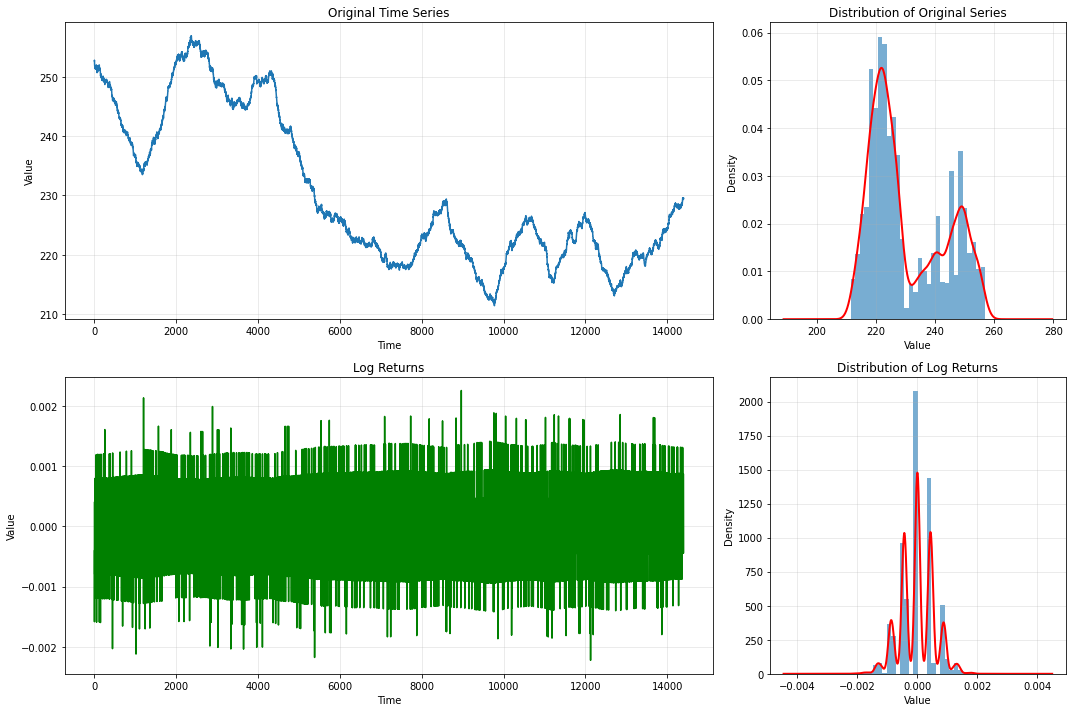

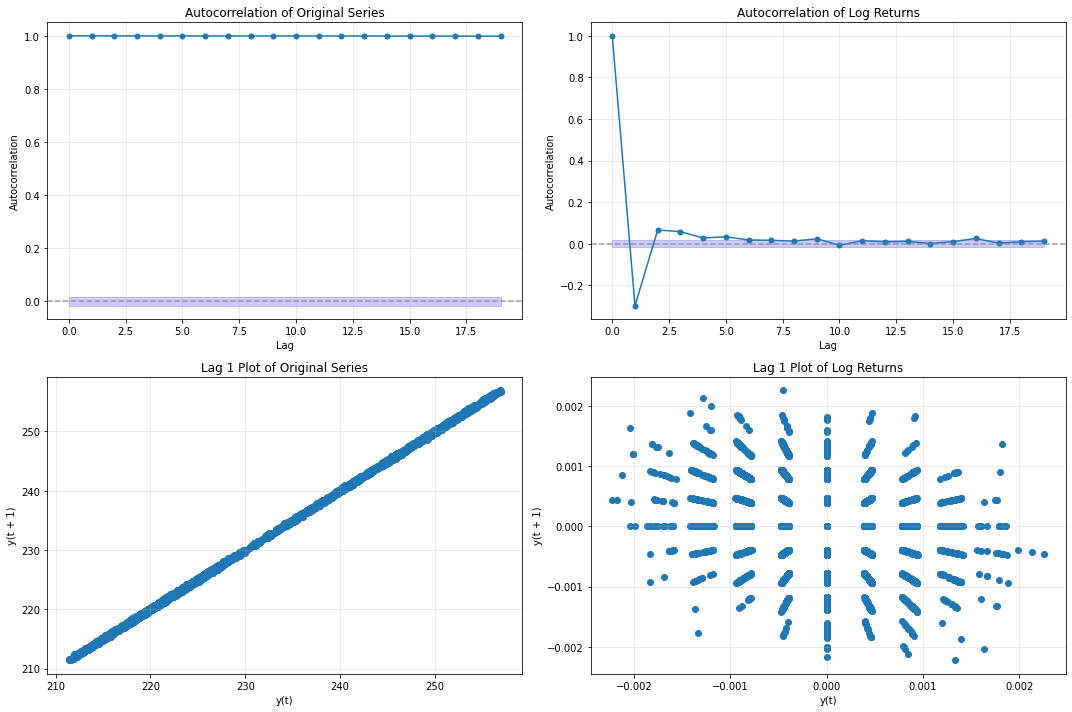

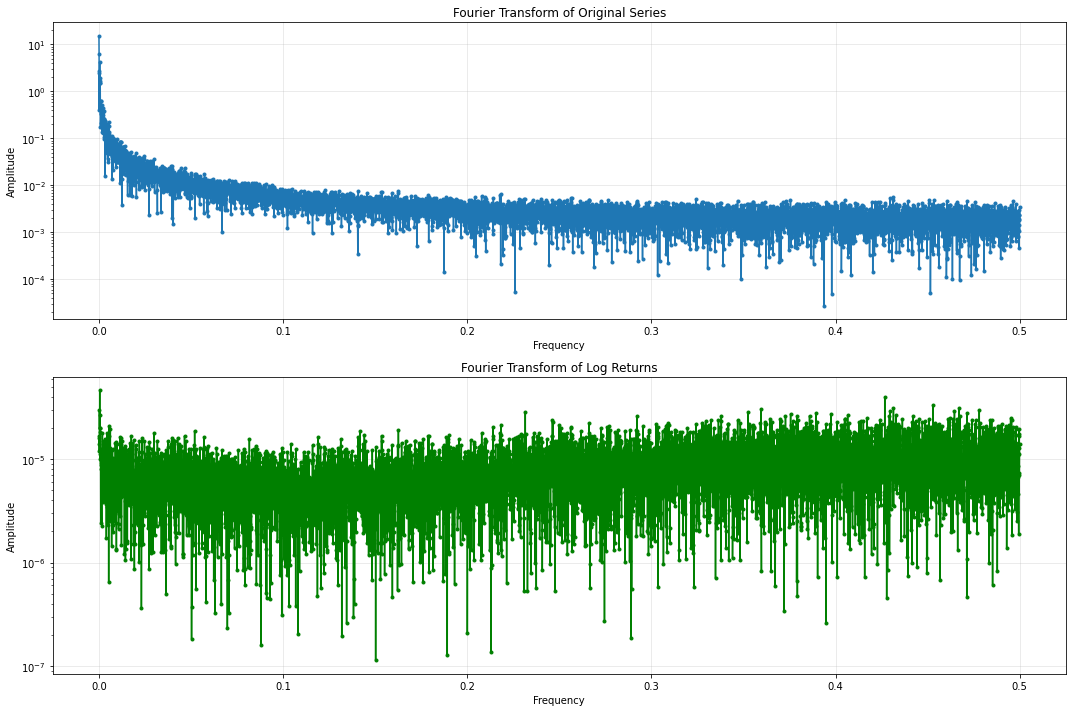

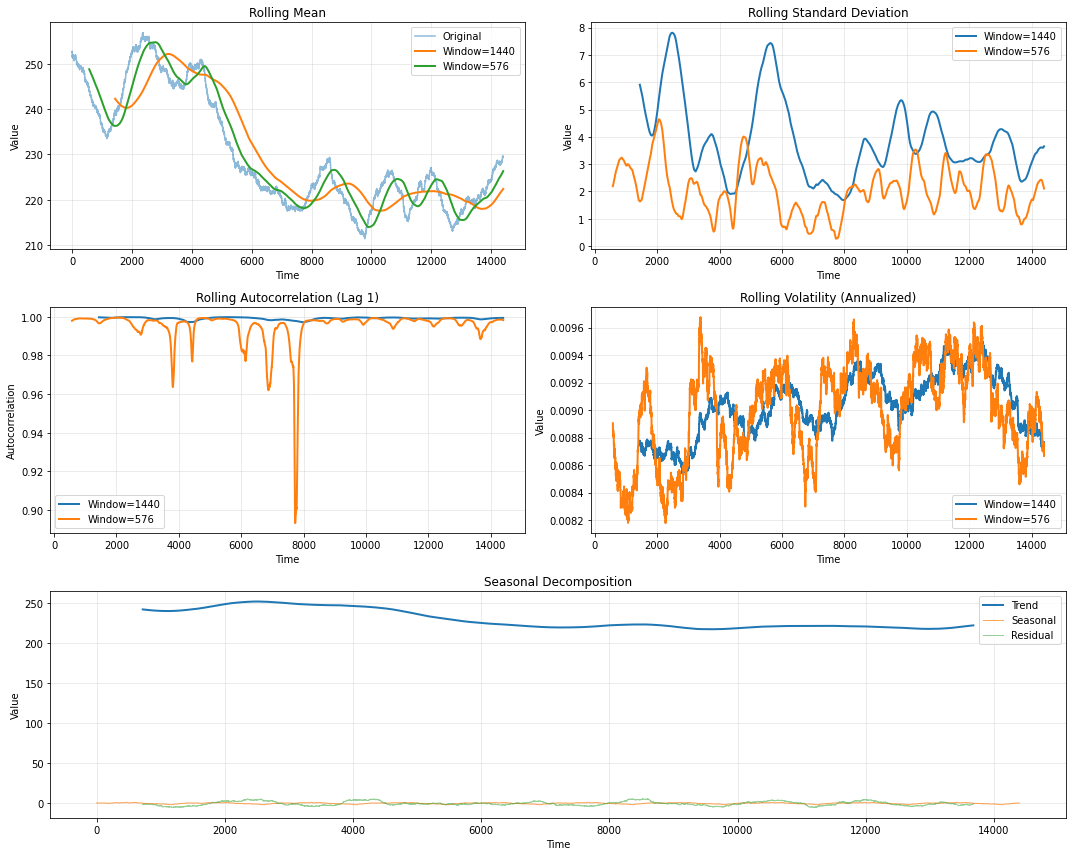

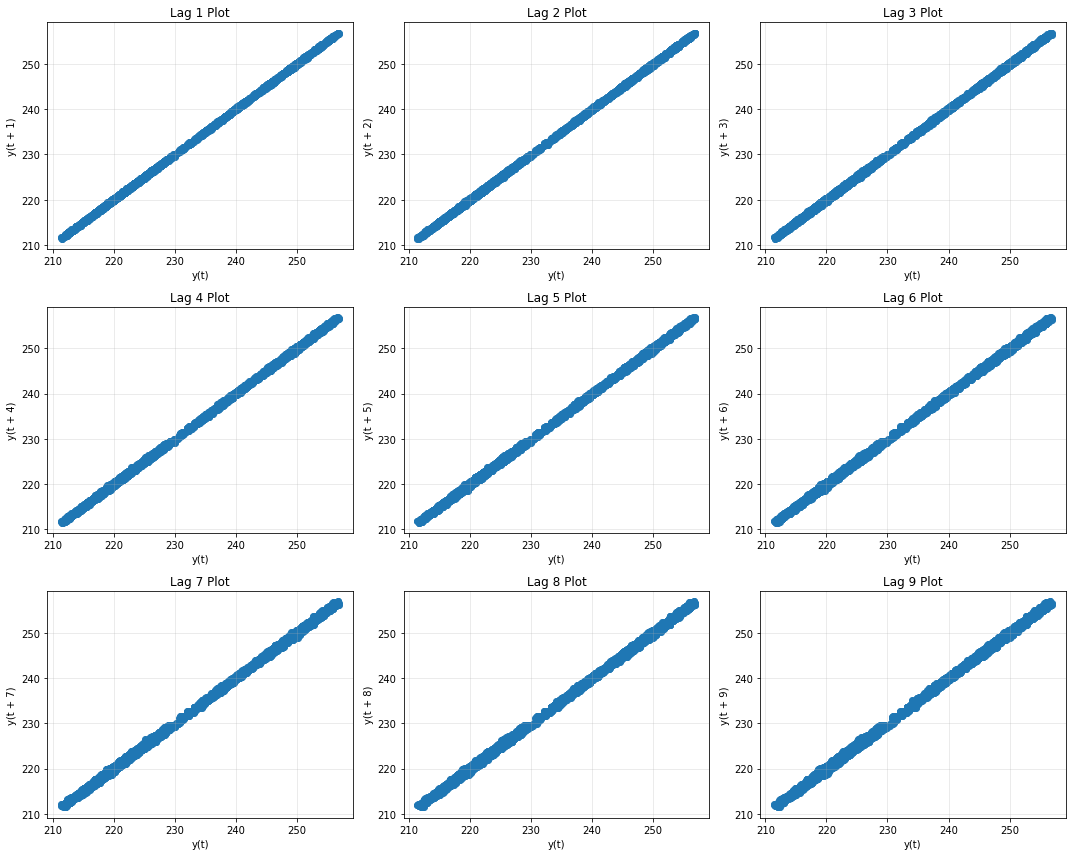

In [78]:
import pandas as pd

data = pd.read_csv('momentum.csv')

series = data['Bid'].values

figs = analyse_time_series(series, ts=data['Timestamp'].values, non_negative=True)

C:\Users\kaima\AppData\Local\Temp\ipykernel_24300\2348829820.py:224: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  lambda x: np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan)
C:\Users\kaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\kaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


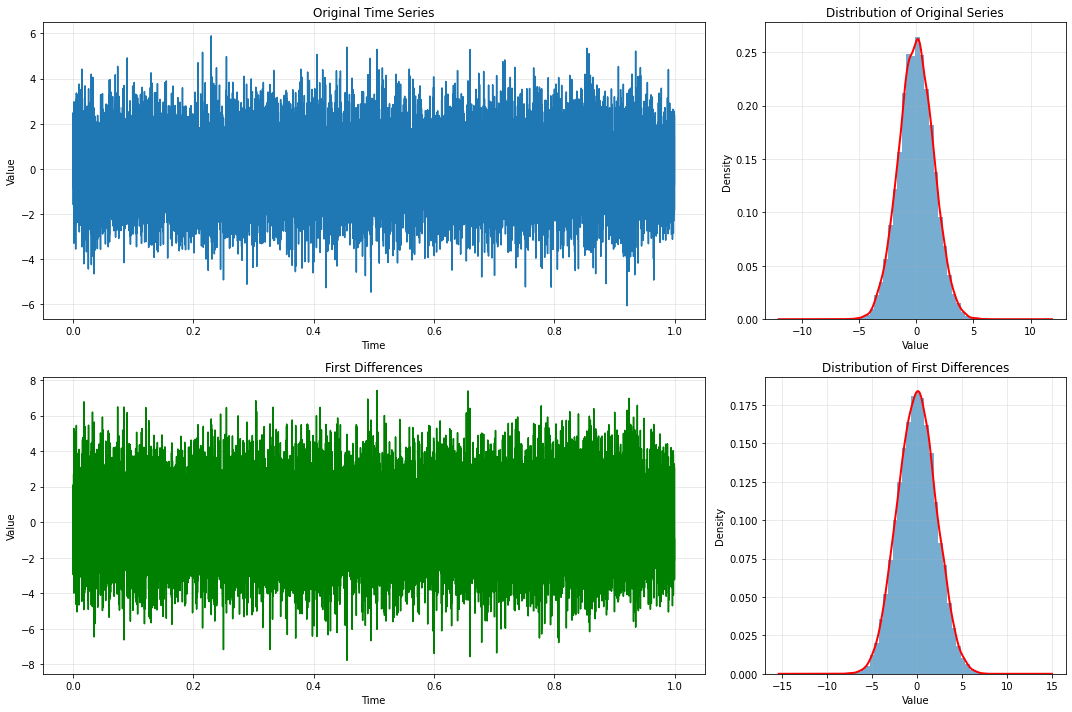

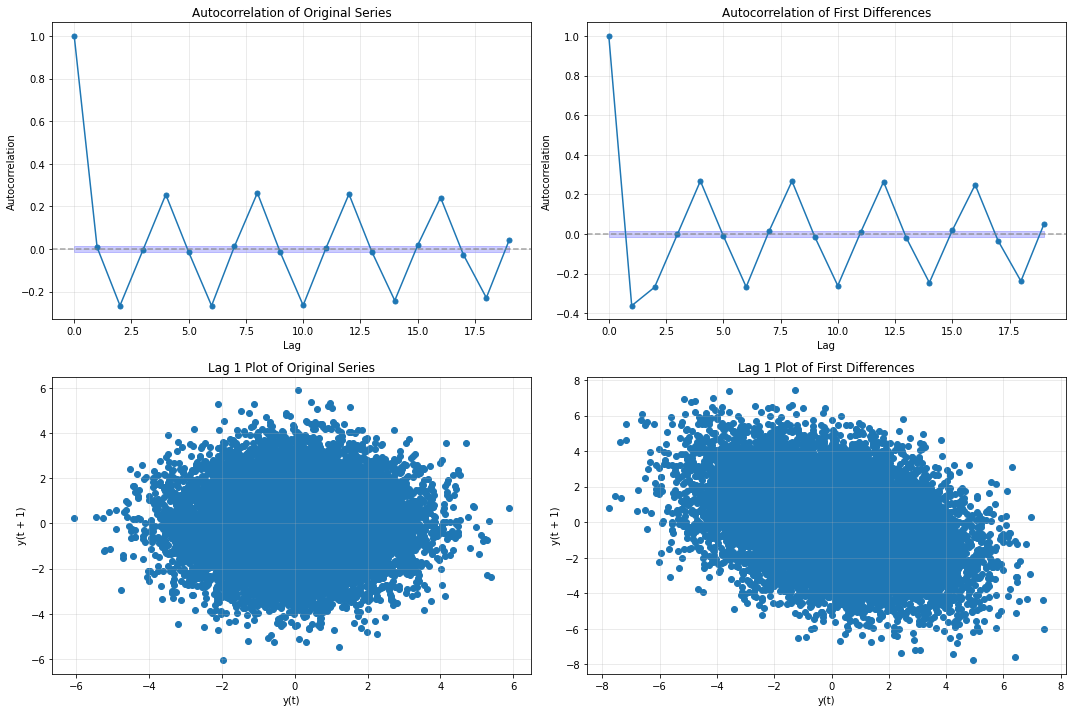

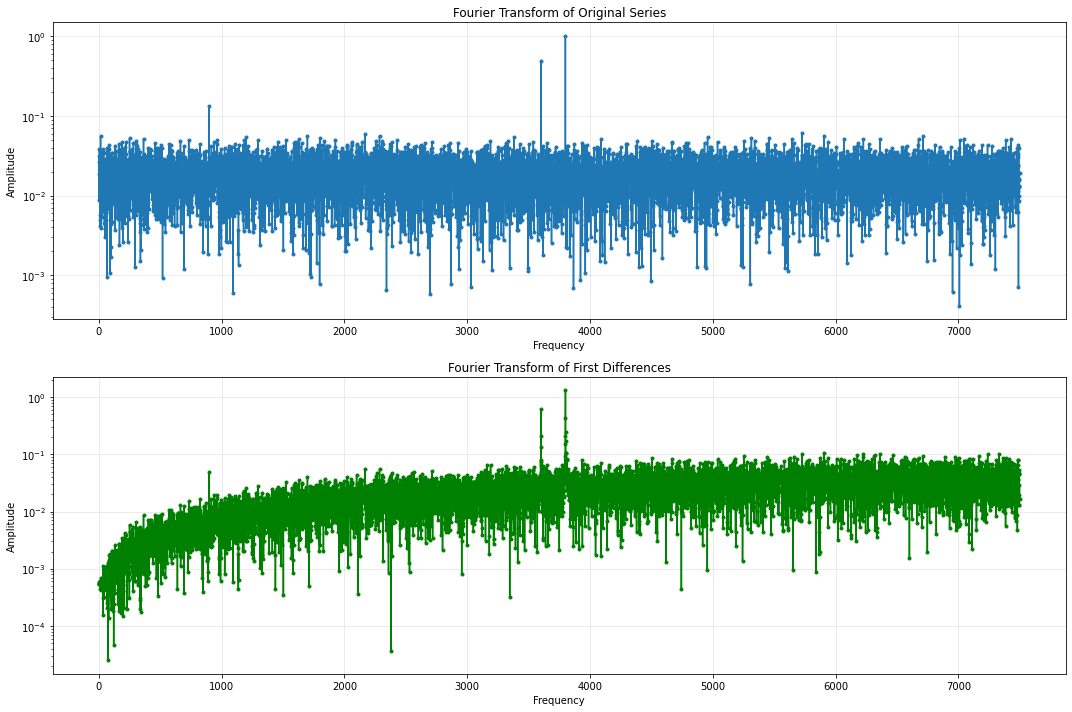

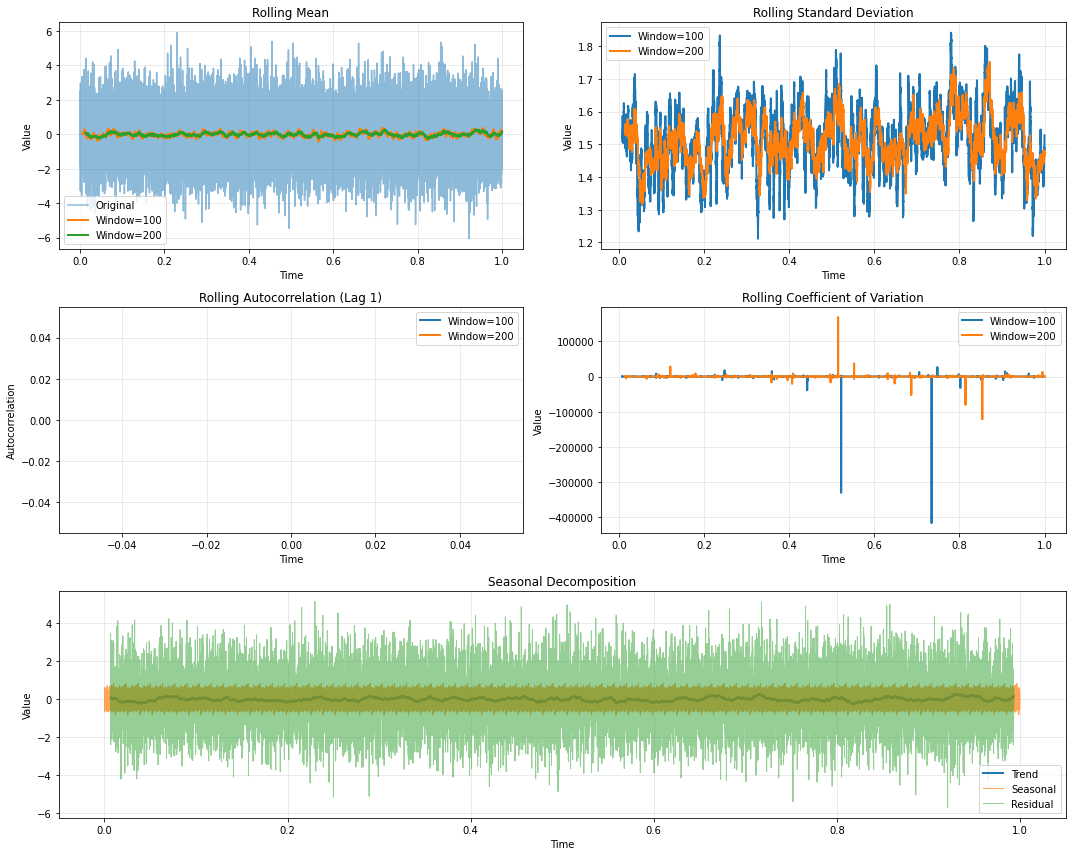

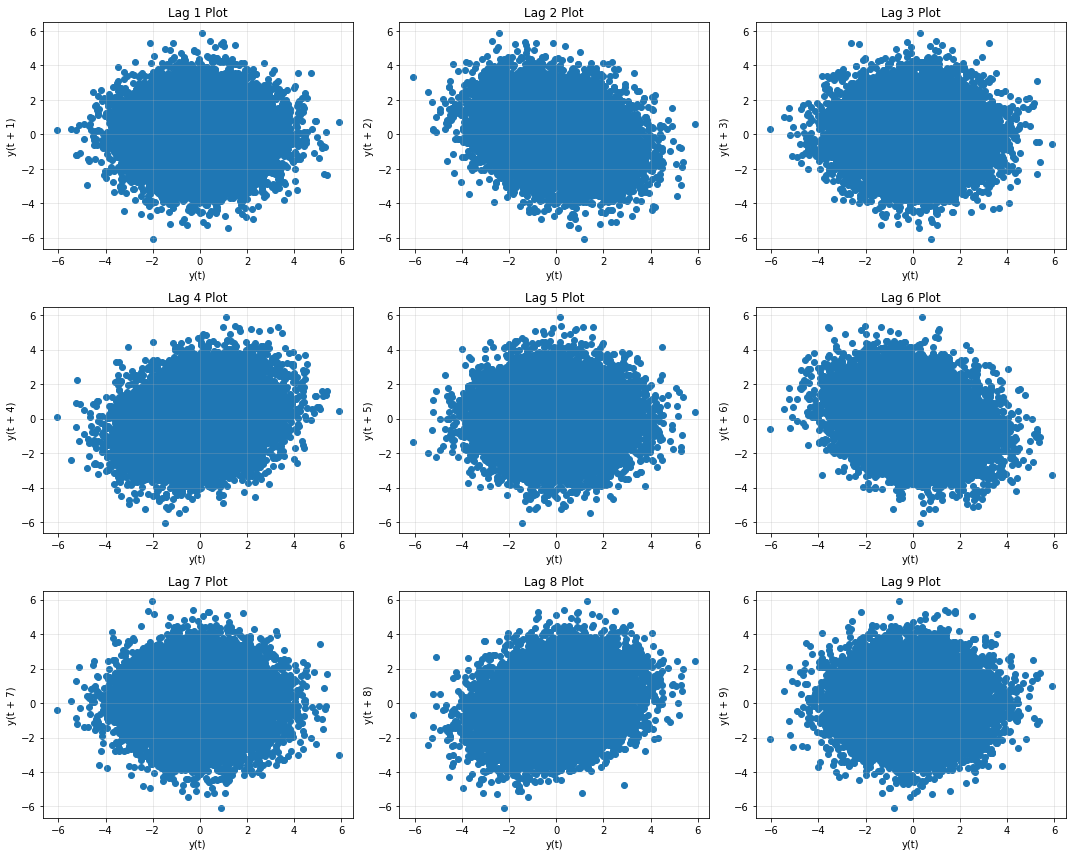

In [104]:
# generate signal of composition of 3 high frequency sin waves
np.random.seed(99)
t = np.linspace(0, 1, 15000, endpoint=False)
signal = np.sin(2 * np.pi * 3800 * t) + 0.5 * np.sin(2 * np.pi * 3600 * t) + 0.1 * np.sin(2 * np.pi * 899 * t)

# add noise
np.random.seed(0)
noise = np.random.normal(0, 1.3, len(t))
signal += noise



figs = analyse_time_series(signal, ts=t, non_negative=False, aut_corr_lags=np.arange(1, 20), windows=[100, 200])


C:\Users\kaima\AppData\Local\Temp\ipykernel_24300\2348829820.py:224: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  lambda x: np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan)
C:\Users\kaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\kaima\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


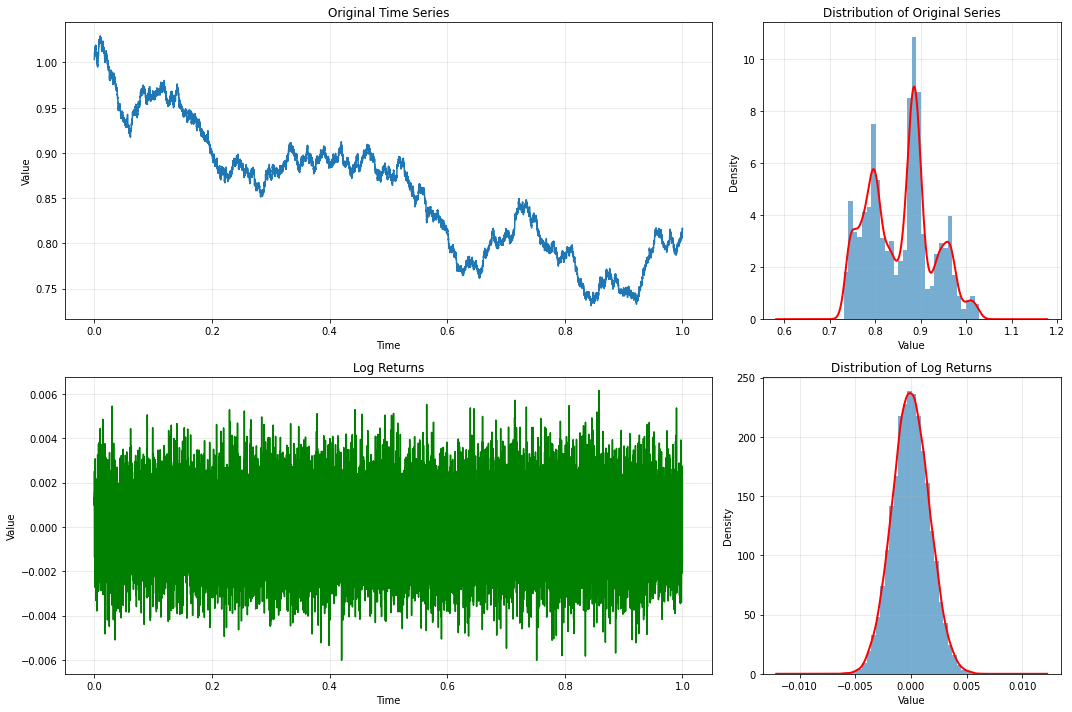

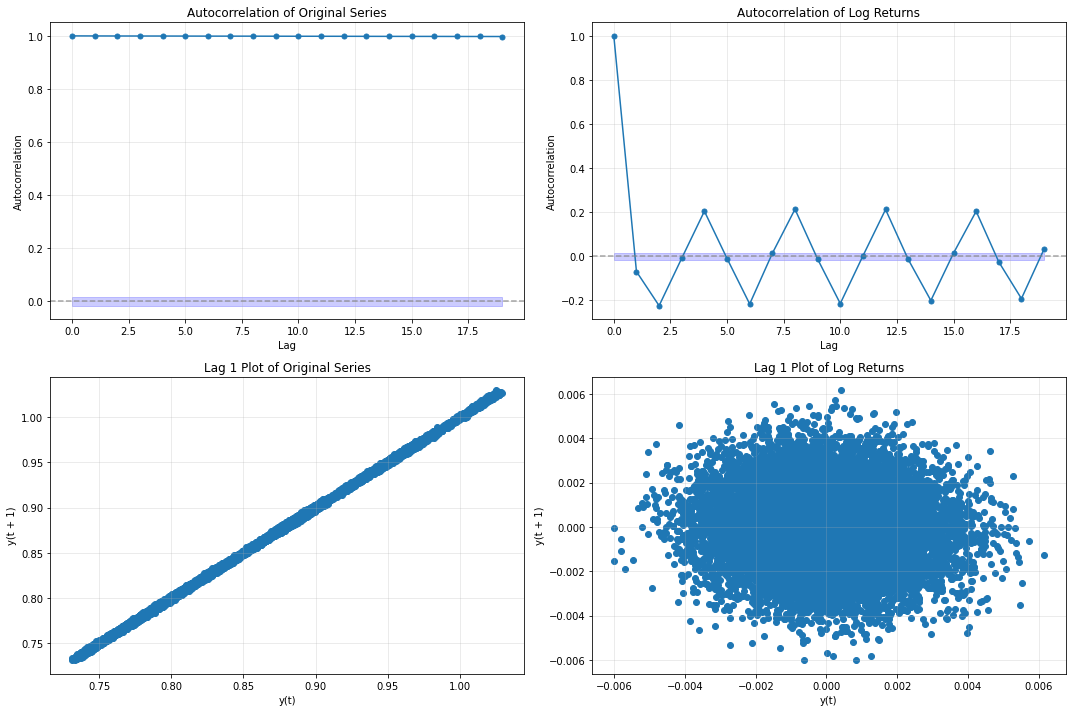

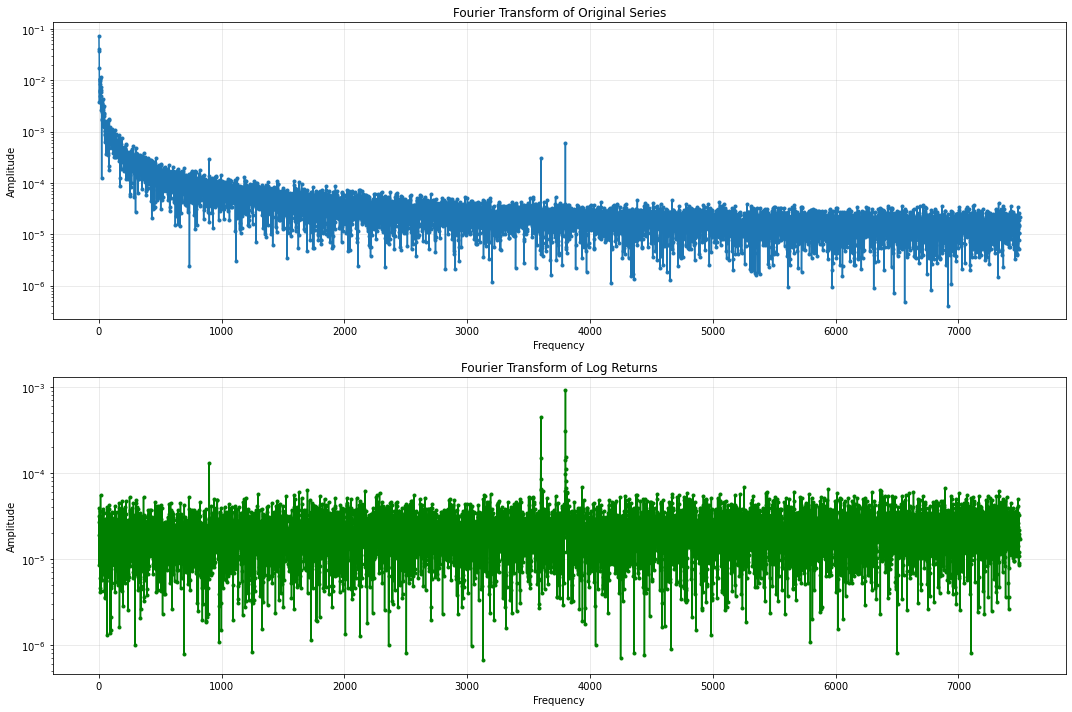

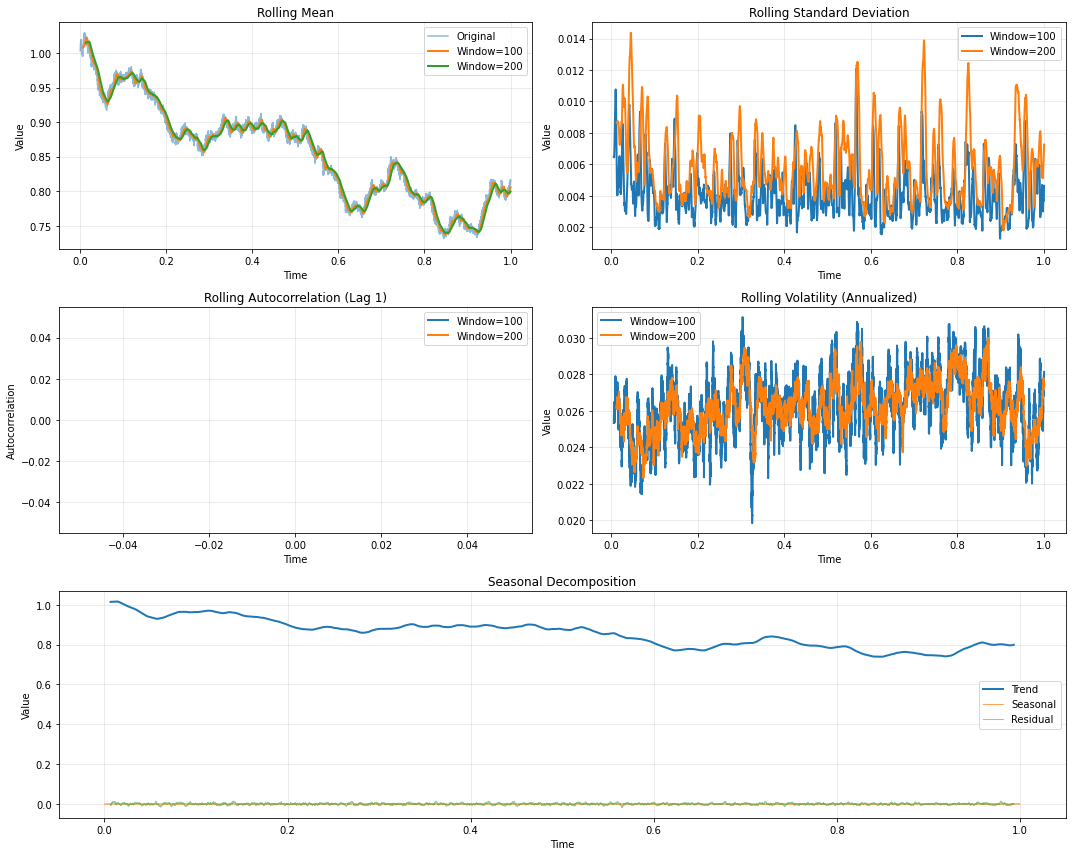

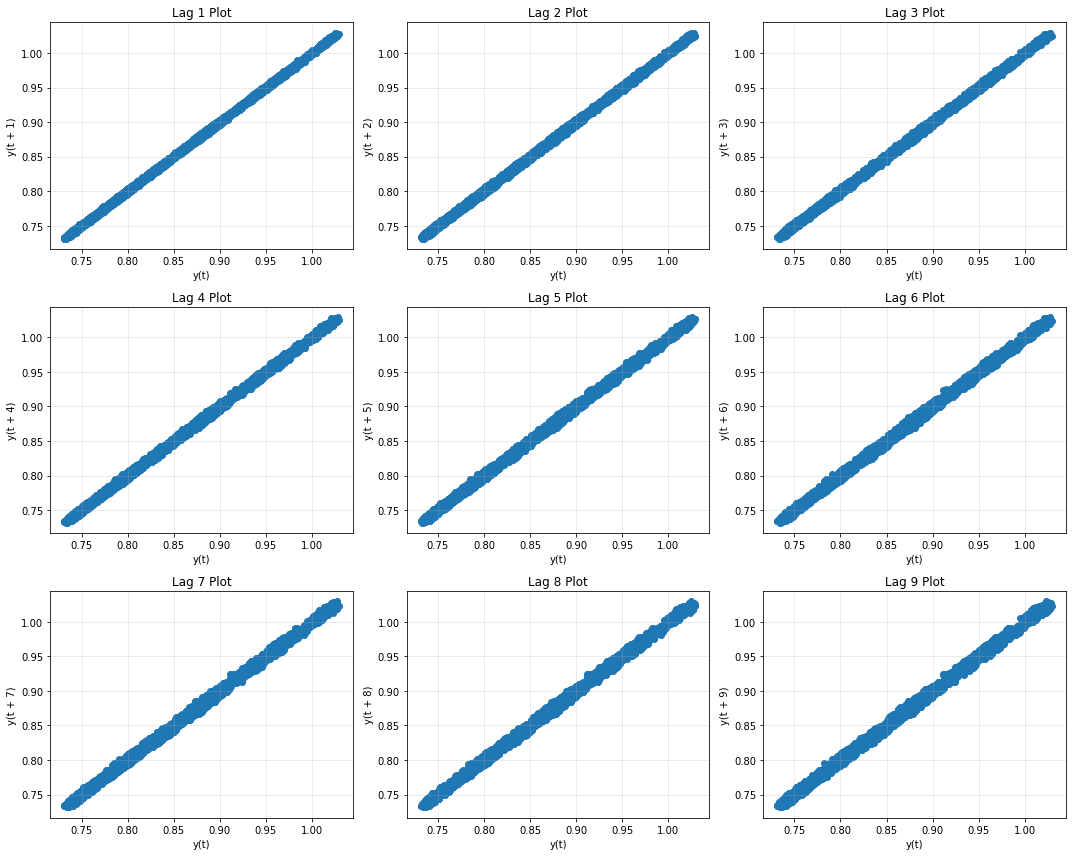

In [105]:
cs = np.exp(np.cumsum(signal)/1000)
cs += np.random.normal(0, 0.0004, len(cs))
figs = analyse_time_series(cs, ts=t, non_negative=True, aut_corr_lags=np.arange(1, 20), windows=[100, 200])
plt.show()

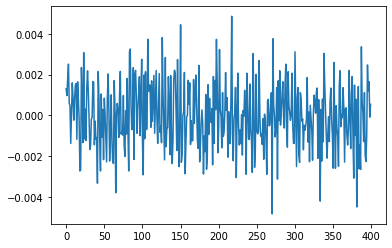

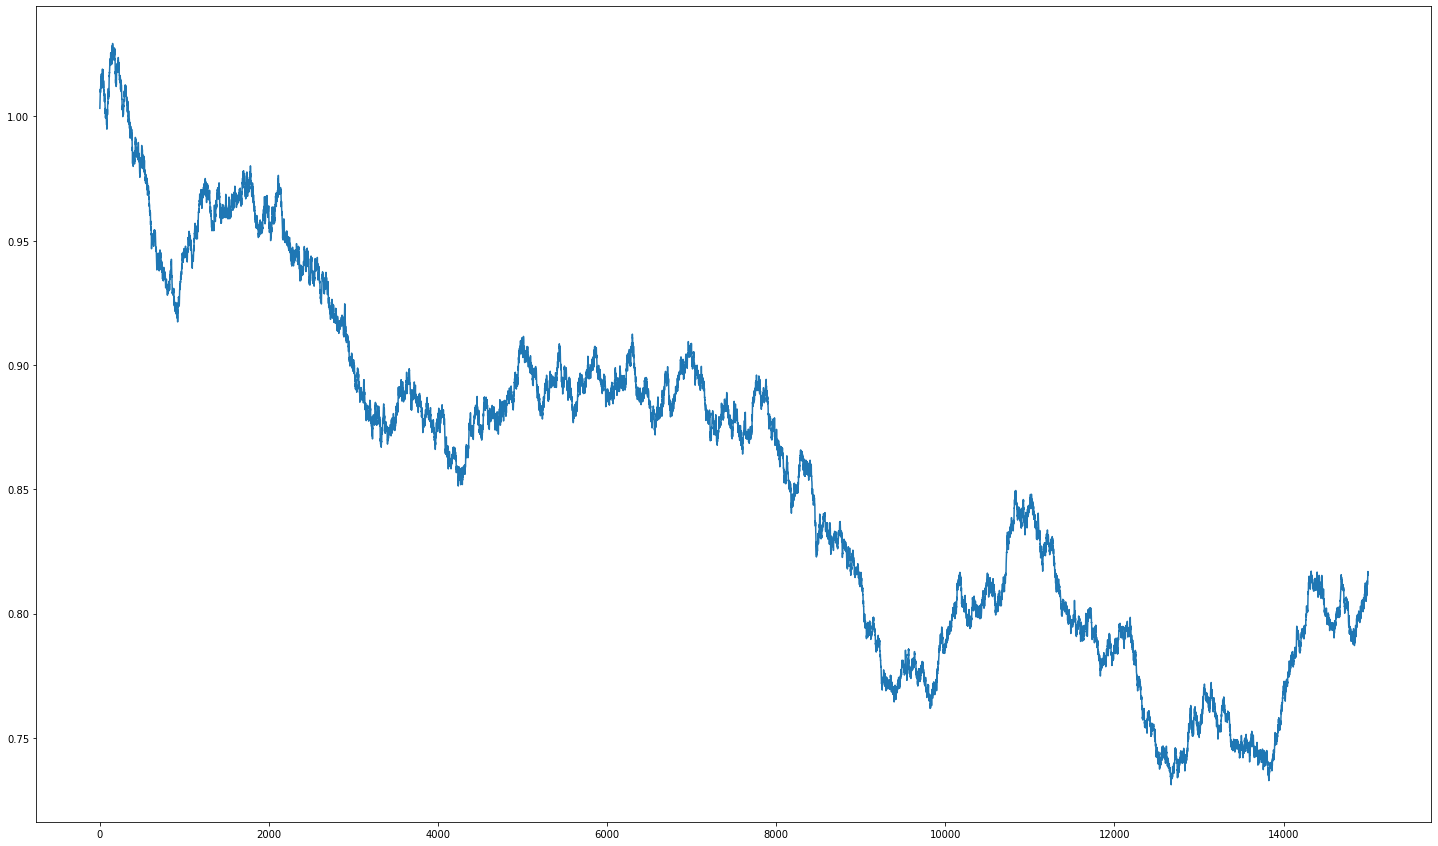

In [106]:
cs_returns= np.log(cs[1:]/cs[:-1])
plt.plot(cs_returns[0:400])
plt.show()

plt.figure(figsize=(25, 15))
plt.plot(cs)
plt.show()

# save csv
df = pd.DataFrame(cs)
#df.to_csv('fourier.csv', index=False)


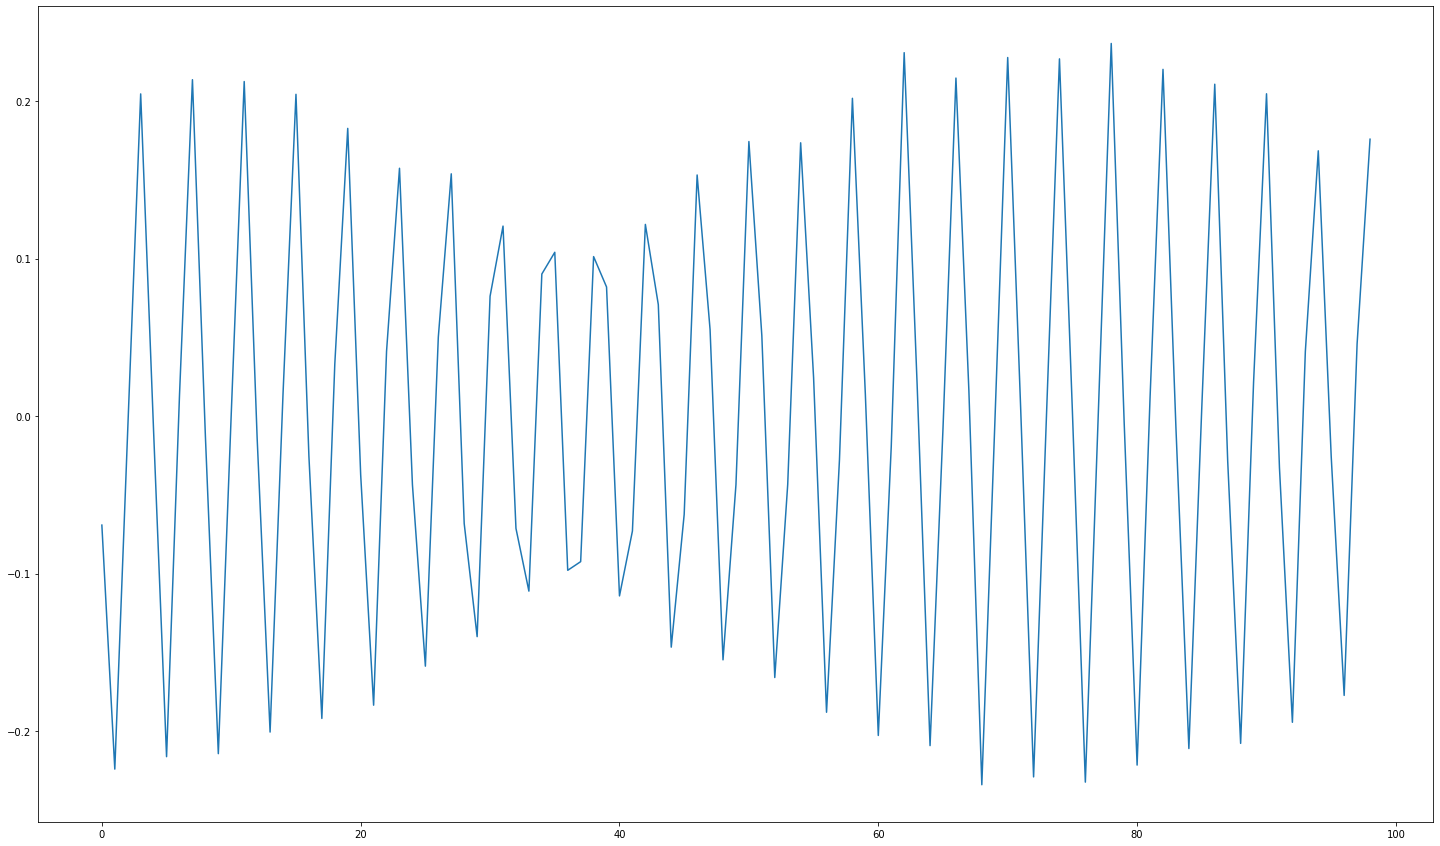

In [107]:
rets= cs[1:]/cs[:-1]


# autocorrelation
plt.figure(figsize=(25, 15))
auts = []
for i in range(1, 100):
    auts.append(np.corrcoef(rets[:-i], rets[i:])[0, 1])
plt.plot(auts)